# These are the Cartography visuals.

# To Do:
- finish snakemake files for zika and seasonal flu, talk about organization with John
- add snakemake commands instead of explicit paths once main snakefile is updated
- add genetic KDE to full plot (create using the scripts)

# Imports Section 

In [5]:
import altair as alt
from augur.utils import json_to_tree
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
#from reportlab.graphics import renderPDF
import seaborn as sns
#from svglib.svglib import svg2rlg

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [2]:
try: 
    snakemake.input.tree 
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


## Pathogen-specific variables

Consider consolidating these into a single configuration file that can be passed to the notebook as a command line argument for more scriptable generation of these figures.

# Flu Specific Variables

In [3]:
try:
    path = snakemake.input.alignment
    dropped_strains = [line.rstrip('\n') for line in open(snakemake.input.dropped_strains,"r")]
    tree_path = snakemake.input.tree
    if snakemake.input.clade_names is not None:
        clades_to_plot = [line.rstrip('\n') for line in open(snakemake.input[len(snakemake.input)-2],"r")]
    f = open(snakemake.input.disease_name, "r")
    virus_name = f.read()
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


### Old Flu Files

In [11]:
#path = "../seasonal-flu-nextstrain/results-20182020/variable_sites.fasta"
dropped_strains = []
tree_path = "../auspice/flu_seasonal_h3n2_ha_2y.json"
virus_name = "Flu"
clades_to_plot = ['3c3.A', 'A3', 'A2/re', 'A2', 'A1b/135N', 'A1b/131K', 'A1b/94N', 'A1b/131K', 'A1b/197R', 'A1b/135K', 'A1b/137F', 'A1b/186D']

# Zika Specific Variables 

In [6]:
path = "../zika-nextstrain/results/aligned.fasta"
tree_path = '../auspice/zika-cartography_tree.json'
virus_name = "Zika"
clades_to_plot = None

# Reading in all the data from the scripts

In [11]:
similarity_matrix = pd.read_csv("../zika-nextstrain/results/distance_matrix.csv", index_col=0)

In [13]:
similarity_matrix.columns = similarity_matrix.index

# Creating the Phylogenetic Tree in Altair
- I used Altair to make this tree (Documentation linked [here][1]
- The data from the JSON and the Data from the tree are usually a little different, so after merging the two dataframes you may get some errors.

[1]: https://altair-viz.github.io/index.html

In [14]:
with open(tree_path) as fh:
    json_tree_handle = json.load(fh)

In [15]:
tree = json_to_tree(json_tree_handle)

In [16]:
tree

Clade(branch_length=0, name='NODE_0000000')

In [17]:
heights = get_y_positions(tree)
for node in tree.find_clades():
    node.yvalue = heights[node]

In [18]:
node_data = [
    {
        "strain": node.name,
        "date": node.node_attrs["num_date"]["value"],
        "y": node.yvalue,
        "region": node.node_attrs["region"]["value"],
        "country": node.node_attrs["country"]["value"],
        "parent_date": node.parent is not None and node.parent.node_attrs["num_date"]["value"] or node.node_attrs["num_date"],
        "parent_y": node.parent is not None and node.parent.yvalue or node.yvalue,
        "clade_membership" : node.node_attrs['clade_membership']["value"]
    }
    for node in tree.find_clades(terminal=True)
]

In [19]:
node_data[10]

{'strain': 'SG_059',
 'date': 2016.6598360655737,
 'y': 11,
 'region': 'southeast_asia',
 'country': 'singapore',
 'parent_date': 2015.7593260199399,
 'parent_y': 11.75,
 'clade_membership': 'c2'}

In [20]:
node_df = pd.DataFrame(node_data)

In [21]:
node_df.head()

strain         date  y          region    country  parent_date  \
0              SG_021  2016.700820  1  southeast_asia  singapore  2011.829976   
1            SI_BKK06  2017.683562  2  southeast_asia   thailand  2011.829976   
2               BKK07  2017.749315  3  southeast_asia   thailand  2014.528418   
3   Thailand/1610acTw  2016.831967  4  southeast_asia   thailand  2015.022368   
4  Thai/KngSG/17_D501  2017.937100  5  southeast_asia   thailand  2015.691507   

   parent_y clade_membership  
0   1.50000       unassigned  
1   1.50000       unassigned  
2   3.96875               c2  
3   4.93750               c2  
4   5.87500               c2

In [22]:
node_df["y"] = node_df["y"].max() - node_df["y"]

In [23]:
node_df["parent_y"] = node_df["parent_y"].max() - node_df["parent_y"]

In [24]:
node_df.shape

(674, 8)

In [25]:
node_df.head()

strain         date    y          region    country  \
0              SG_021  2016.700820  673  southeast_asia  singapore   
1            SI_BKK06  2017.683562  672  southeast_asia   thailand   
2               BKK07  2017.749315  671  southeast_asia   thailand   
3   Thailand/1610acTw  2016.831967  670  southeast_asia   thailand   
4  Thai/KngSG/17_D501  2017.937100  669  southeast_asia   thailand   

   parent_date   parent_y clade_membership  
0  2011.829976  672.00000       unassigned  
1  2011.829976  672.00000       unassigned  
2  2014.528418  669.53125               c2  
3  2015.022368  668.56250               c2  
4  2015.691507  667.62500               c2

In [26]:
node_df["region"].unique()

array(['southeast_asia', 'oceania', 'china', 'south_america',
       'north_america', 'africa', 'japan_korea'], dtype=object)

In [27]:
# Reannotate clades that we aren't interested in as "other" to simplify color assignment in visualizations.
try:
    node_df["clade_membership_color"] = node_df["clade_membership"].apply(lambda clade: clade if clade in clades_to_plot else "other")
except:
    node_df["clade_membership_color"] = node_df["clade_membership"]
    print("clades_to_plot undefined")

clades_to_plot undefined


In [28]:
indices_to_drop = similarity_matrix[~similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix[similarity_matrix.index.isin(node_df["strain"])].dropna(how = 'all')
similarity_matrix = similarity_matrix.drop(indices_to_drop.index, axis=1)
similarity_matrix

FrenchPolynesia2014_060114_016  1_0049_PF  \
FrenchPolynesia2014_060114_016                               0         13   
1_0049_PF                                                   13          0   
1_0030_PF                                                   13         13   
1_0035_PF                                                   14         14   
1_0087_PF                                                   11         11   
...                                                        ...        ...   
MEX/2016/mex45                                              21         20   
Bahia15                                                     10          8   
NIC/5847_12B1/2016                                          23         22   
USA/2016/FLUR005                                            27         24   
USA/2016/FLUR001                                            24         21   

                                1_0030_PF  1_0035_PF  1_0087_PF  1_0181_PF  \
FrenchPolynesia2014_060114_016         13         14         11         10   
1_0049_PF                              13         14         11         10   
1_0030_PF                               0         11          8          9   
1_0035_PF                              11          0          7         10   
1_0087_PF                               8          7          0          7   
...                                   ...        ...        ...        ...   
MEX/2016/mex45                         22         24         21         20   
Bahia15                                 9         10          9          8   
NIC/5847_12B1/2016                     24         21         21         21   
USA/2016/FLUR005                       26         25         24         23   
USA/2016/FLUR001                       20         22         19         22   

                                1_0015_PF  H/PF/2013  TS17_2016  1_0199_PF  \
FrenchPolynesia2014_060114_016         13         12         24          8   
1_0049_PF                              13         12         24          8   
1_0030_PF                              12          9         21          8   
1_0035_PF                              13          8         22          9   
1_0087_PF                              10          5         19          6   
...                                   ...        ...        ...        ...   
MEX/2016/mex45                         21         21         28         20   
Bahia15                                 9          7         13          7   
NIC/5847_12B1/2016                     19         21         27         15   
USA/2016/FLUR005                       25         24         28         18   
USA/2016/FLUR001                       22         19         27         13   

                                ...  MEX/2016/mex04  USA/2016/FL029  \
FrenchPolynesia2014_060114_016  ...              25              25   
1_0049_PF                       ...              21              22   
1_0030_PF                       ...              25              25   
1_0035_PF                       ...              24              26   
1_0087_PF                       ...              23              24   
...                             ...             ...             ...   
MEX/2016/mex45                  ...              10              12   
Bahia15                         ...              17              12   
NIC/5847_12B1/2016              ...              10              20   
USA/2016/FLUR005                ...              23               7   
USA/2016/FLUR001                ...              18               8   

                                COL/2016/SU_2293A  MEX/2016/mex38  \
FrenchPolynesia2014_060114_016                 19              19   
1_0049_PF                                      12              18   
1_0030_PF                                      16              21   
1_0035_PF                                      16              25   
1_0087_PF                          

In [29]:
node_df

strain         date    y          region    country  \
0                    SG_021  2016.700820  673  southeast_asia  singapore   
1                  SI_BKK06  2017.683562  672  southeast_asia   thailand   
2                     BKK07  2017.749315  671  southeast_asia   thailand   
3         Thailand/1610acTw  2016.831967  670  southeast_asia   thailand   
4        Thai/KngSG/17_D501  2017.937100  669  southeast_asia   thailand   
..                      ...          ...  ...             ...        ...   
669  MEX/41_001_F_V7_O/2016  2016.490437    4   north_america     mexico   
670  MEX/41_001_F_V3_O/2016  2016.476776    3   north_america     mexico   
671  MEX/41_017_F_V7_O/2016  2016.621585    2   north_america     mexico   
672  MEX/41_017_F_V0_O/2016  2016.602459    1   north_america     mexico   
673  MEX/41_017_F_V3_O/2016  2016.607923    0   north_america     mexico   

     parent_date   parent_y clade_membership clade_membership_color  
0    2011.829976  672.00000       unassigned             unassigned  
1    2011.829976  672.00000       unassigned             unassigned  
2    2014.528418  669.53125               c2                     c2  
3    2015.022368  668.56250               c2                     c2  
4    2015.691507  667.62500               c2                     c2  
..           ...        ...              ...                    ...  
669  2016.476776    3.00000               c4                     c4  
670  2016.476776    3.00000               c4                     c4  
671  2016.468066    0.75000               c4                     c4  
672  2016.602459    0.00000               c4                     c4  
673  2016.602459    0.00000               c4                     c4  

[674 rows x 9 columns]

# Running PCA on Scaled and Centered Data
- I treated each nucleotide as a "site", or dimension, and found the probability of having a certain nucleotide given the frequency of that letter at that site.
- I used [this paper][1] as my source 
- The equation is as follows where C is the matrix of dimensions, M is the mean, and p is the frequency of a nucleotide at that given site. 
![](https://journals.plos.org/plosgenetics/article/file?type=thumbnail&id=info:doi/10.1371/journal.pgen.0020190.e003)

In [36]:
#principalDf = pd.read_csv(snakemake.input.pca)
principalDf = pd.read_csv("../zika-nextstrain/results/embed_pca.csv", index_col=0)

In [37]:
#explained_variance_df = pd.read_csv(snakemake.input.pca + "explained_variance")
explained_variance_df = pd.read_csv("../seasonal-flu-nextstrain/results/explained_variance_pca.csv")
explained_variance_df

explained variance  principal components
0              0.2701                     0
1              0.1567                     1
2              0.0930                     2
3              0.0586                     3
4              0.0275                     4
5              0.0225                     5
6              0.0183                     6
7              0.0174                     7
8              0.0140                     8
9              0.0110                     9

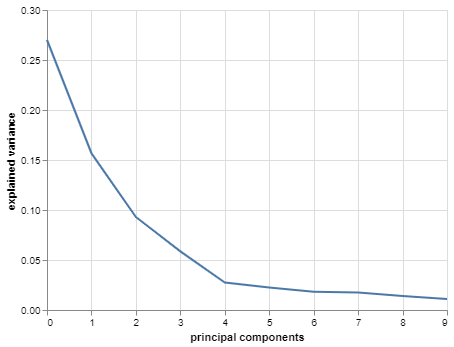

In [38]:
chart = alt.Chart(explained_variance_df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart

In [39]:
merged_pca_df = principalDf.merge(node_df, on="strain")

In [40]:
merged_pca_df.head()

strain       pca1       pca2       pca3      pca4  \
0  FrenchPolynesia2014_060114_016  -6.456840 -34.988758 -14.897723 -9.817759   
1                       1_0049_PF -20.795183  -3.751525  -5.387696 -4.609604   
2                       1_0030_PF -20.880744  -3.752583  -5.306240 -4.397557   
3                       1_0035_PF -20.862839  -3.737762  -5.313358 -4.394425   
4                       1_0087_PF -20.854980  -3.807463  -5.356183 -4.424798   

       pca5      pca6      pca7      pca8      pca9     pca10  label  \
0 -2.919461  2.807169 -6.223433 -2.453945  1.061307  2.168560      0   
1 -5.578410 -1.175741 -7.821439  0.551473 -8.452394  2.256111     -1   
2 -5.428613 -0.982344 -7.807278  0.542083 -8.364944  2.356674     -1   
3 -5.443108 -0.931320 -7.811396  0.550424 -8.388051  2.360109     -1   
4 -5.449888 -0.918410 -7.781177  0.521749 -8.376723  2.363700     -1   

          date    y   region           country  parent_date  parent_y  \
0  2014.015068  521  oceania  french_polynesia  2013.767920  520.0000   
1  2013.998630  514  oceania  french_polynesia  2013.554017  514.0000   
2  2013.913699  545  oceania  french_polynesia  2013.371193  543.5625   
3  2014.083562  544  oceania  french_polynesia  2013.542520  542.6250   
4  2013.983976  542  oceania  french_polynesia  2013.702930  541.0000   

  clade_membership clade_membership_color  
0               c1                     c1  
1               c1                     c1  
2               c1                     c1  
3               c1                     c1  
4               c1                     c1

In [41]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

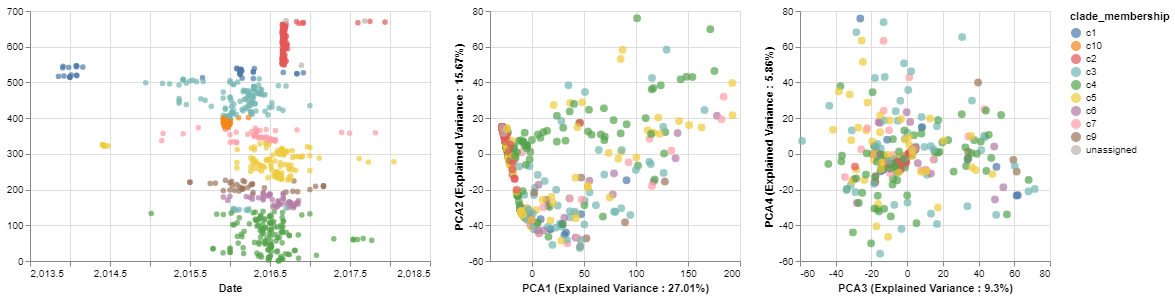

In [42]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain','region', "clade_membership"])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

# HDBSCAN Output

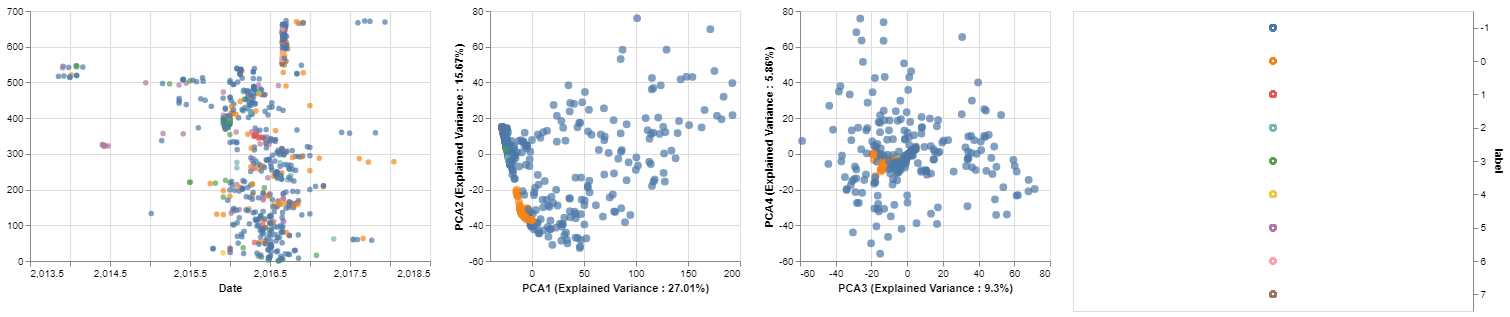

In [43]:
list_of_chart = linking_tree_with_plots_clickable(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "label:N",["label"], ['strain','region'])
PCAFluBrush = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[4]

PCAFluBrush
#PCAFluBrush.save("docs/PCA" + virus_name + "Brush.html")

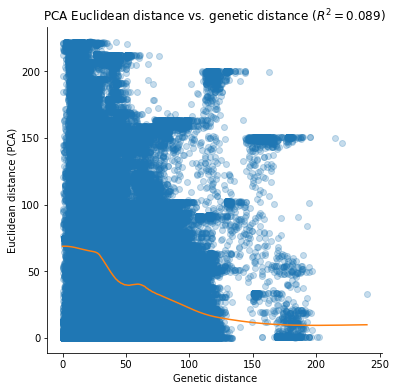

In [50]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_PCA = pd.read_csv("../zika-nextstrain/results/scatterplot_pca.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_PCA["pearson_coef"].values.tolist()[0]))

sns.despine()

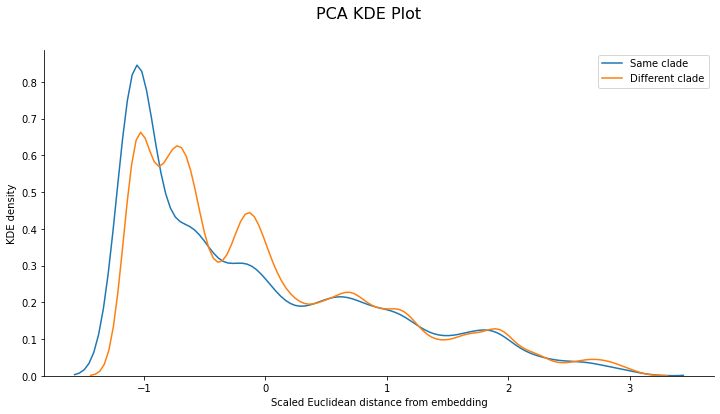

In [51]:
PCA_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_pca.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('PCA KDE Plot', fontsize=16)
sns.despine()

# Running MDS on the Dataset

In [44]:
#principalDf = pd.read_csv(snakemake.input.pca)
MDS_df = pd.read_csv("../zika-nextstrain/results/embed_mds.csv",index_col=0)

In [45]:
merged_mds_df = MDS_df.merge(node_df, on="strain")

In [46]:
merged_mds_df

strain       mds1      mds2      mds3      mds4  \
0    FrenchPolynesia2014_060114_016  10.572894 -5.239227 -2.260195  3.744414   
1                         1_0049_PF   3.157954 -4.891433 -3.035117  3.926068   
2                         1_0030_PF   8.172553 -6.028724 -1.370719  6.331783   
3                         1_0035_PF   9.046493 -6.452458 -0.788629  7.185421   
4                         1_0087_PF   5.805219 -4.592330 -0.427391  5.658028   
..                              ...        ...       ...       ...       ...   
669                  MEX/2016/mex45   0.464687  0.084359  3.089321  0.004048   
670                         Bahia15  -0.118938  0.282687 -0.790580  0.183668   
671              NIC/5847_12B1/2016  -1.021184 -2.480286  2.114183 -0.018341   
672                USA/2016/FLUR005   2.475811  7.814513 -5.408679 -2.452379   
673                USA/2016/FLUR001   1.602143  5.383969 -5.849401 -1.929793   

         mds5      mds6      mds7      mds8      mds9     mds10  label  \
0    1.084923 -2.071846  8.124330  5.103464  1.033423 -0.543782      0   
1   -1.789035 -1.394797  6.743468  4.972675 -2.130071  2.492731      0   
2   -0.998589  1.341994  7.963689  6.099410  1.610906 -1.393372      0   
3   -1.597499  3.335617  8.033080  6.429288  1.310622  0.748517      0   
4   -1.620281  0.933428  6.454193  5.680727  1.460602 -0.426860      0   
..        ...       ...       ...       ...       ...       ...    ...   
669 -0.796152 -0.977390 -0.379248 -1.945912 -1.964151 -1.751762      0   
670 -0.662483 -0.028558  0.525033  0.879661  0.396157  0.345380      0   
671  0.431344 -1.127154 -0.368402 -2.737252 -3.166217 -1.056797      0   
672 -5.764494  2.481942 -1.290682  2.455368 -4.794146 -1.051406      0   
673 -5.041946  1.267728 -1.073081  2.566066 -4.936301 -0.041780      0   

            date    y         region           country  parent_date  \
0    2014.015068  521        oceania  french_polynesia  2013.767920   
1    2013.998630  514        oceania  french_polynesia  2013.554017   
2    2013.913699  545        oceania  french_polynesia  2013.371193   
3    2014.083562  544        oceania  french_polynesia  2013.542520   
4    2013.983976  542        oceania  french_polynesia  2013.702930   
..           ...  ...            ...               ...          ...   
669  2016.498634  105  north_america            mexico  2015.002066   
670  2016.001366  505  south_america            brazil  2015.352878   
671  2016.102459   50  north_america         nicaragua  2015.692124   
672  2016.575137  245  north_america               usa  2016.281850   
673  2016.572404  240  north_america               usa  2016.227872   

       parent_y clade_membership clade_membership_color  
0    520.000000               c1                     c1  
1    514.000000               c1                     c1  
2    543.562500               c1                     c1  
3    542.625000               c1                     c1  
4    541.000000               c1                     c1  
..          ...              ...                    ...  
669  105.000000               c4                     c4  
670  504.125000               c3                     c3  
671   48.500000               c4                     c4  
672  245.000000               c5                     c5  
673  236.898438               c5                     c5  

[674 rows x 20 columns]

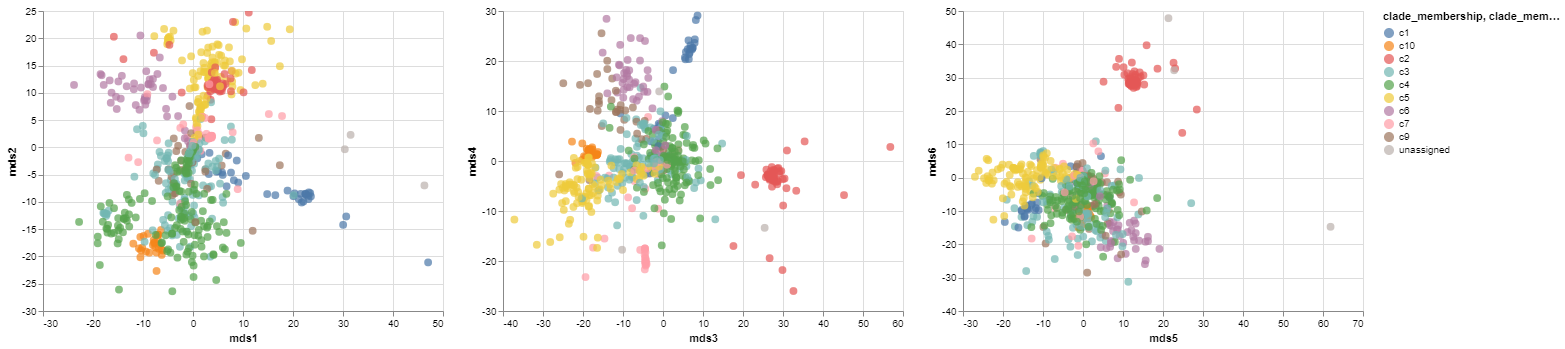

In [47]:
chart_12_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain','clade_membership'],'clade_membership:N')
chart_34_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds3','mds4',"mds3","mds4",['strain','clade_membership'],'clade_membership_color')
chart_56_mds = scatterplot_with_tooltip_interactive(merged_mds_df,'mds5','mds6',"mds5","mds6",['strain','clade_membership'],'clade_membership_color')
chart_12_mds|chart_34_mds|chart_56_mds

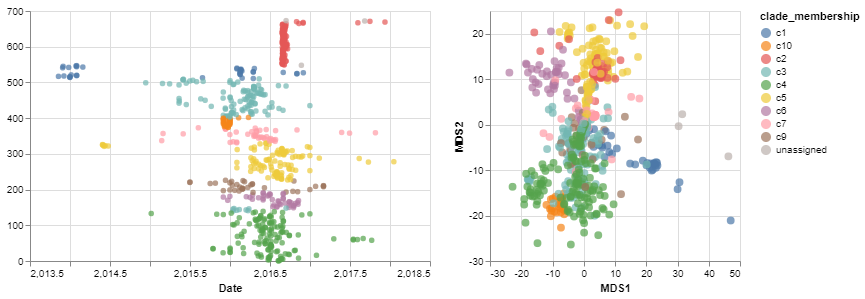

In [48]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]

# HDBSCAN output:

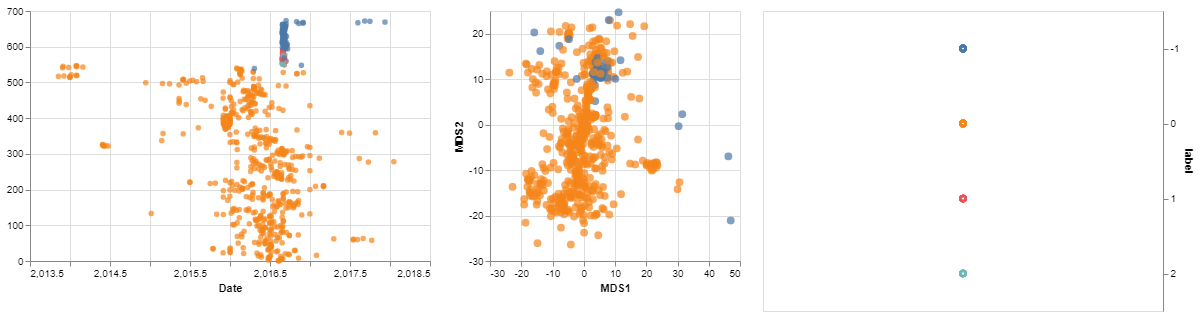

In [49]:
list_of_chart = linking_tree_with_plots_clickable(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'label:N', ["label"], ['strain','clade_membership'])
list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

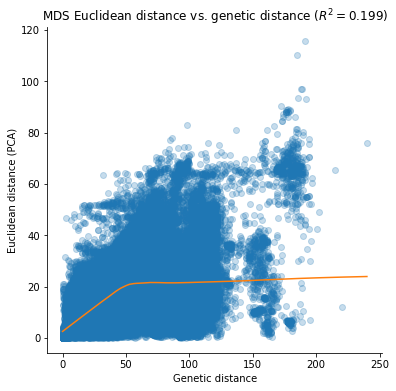

In [52]:
#total_df = pd.read_csv(snakemake.input.pca.replace(".csv", "") + "scatterplot.csv", index_col=0)
total_df_MDS = pd.read_csv("../zika-nextstrain/results/scatterplot_mds.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (PCA)")
ax.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_MDS["pearson_coef"].values.tolist()[0]))

sns.despine()

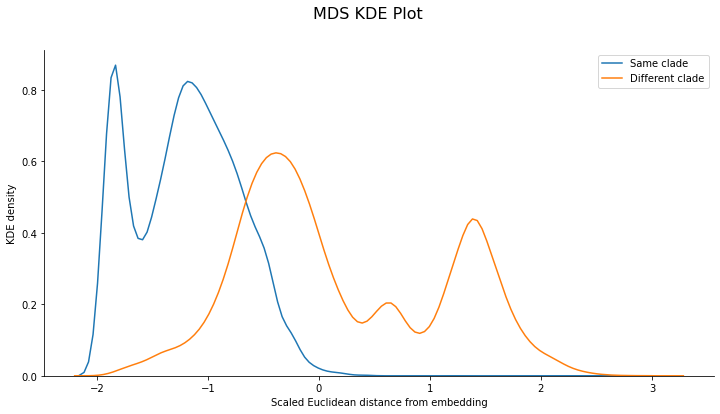

In [53]:
MDS_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_mds.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('MDS KDE Plot', fontsize=16)
sns.despine()

# Running T-SNE on the Dataset 

In [54]:
#principalDf = pd.read_csv(snakemake.input.pca)
TSNE_df = pd.read_csv("../zika-nextstrain/results/embed_t-sne.csv",index_col=0)

In [55]:
TSNE_df

tsne_x     tsne_y  label
strain                                                     
KX369547.1                      -1.470917  12.076694      4
FrenchPolynesia2014_060114_016  -3.350555  11.621268      4
1_0049_PF                       -0.072260  11.418479      4
1_0030_PF                       -1.794666  12.644344      4
1_0035_PF                       -2.375444  12.332663      4
...                                   ...        ...    ...
MEX/2016/mex45                  -5.065586   2.570898      4
Bahia15                         -1.949403   9.534780      4
NIC/5847_12B1/2016              -0.949289   1.634869      4
USA/2016/FLUR005               -14.347694   8.452306      4
USA/2016/FLUR001               -14.208701   8.379222      4

[690 rows x 3 columns]

In [56]:
merged_tsne_df = TSNE_df.merge(node_df, on="strain")

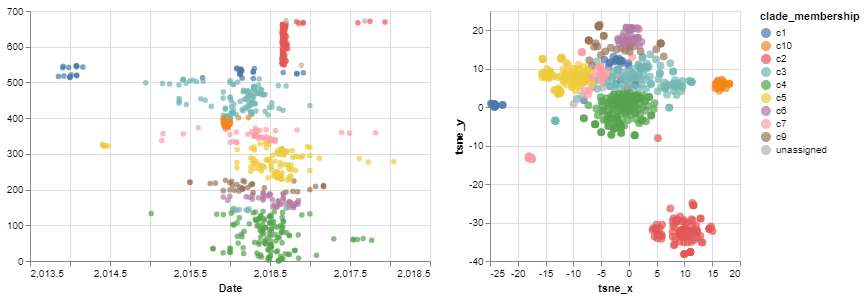

In [57]:
list_of_chart = linking_tree_with_plots_brush(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership',
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

# HDBSCAN Output

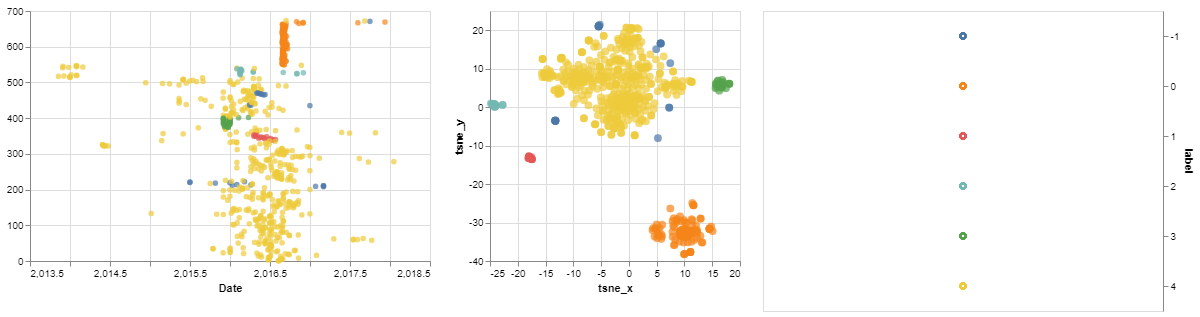

In [58]:
list_of_chart = linking_tree_with_plots_clickable(
    merged_tsne_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'label:N',
    ['label'],
    ["clade_membership:N","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/TSNE" + virus_name + "Brush.html")

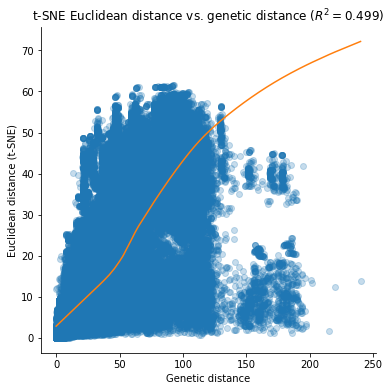

In [59]:
total_df_TSNE = pd.read_csv("../zika-nextstrain/results/scatterplot_t-sne.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (t-SNE)")
ax.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_TSNE["pearson_coef"].values.tolist()[0]))

sns.despine()
#plt.savefig("docs/TSNEScatterplot" + virus_name + ".png")

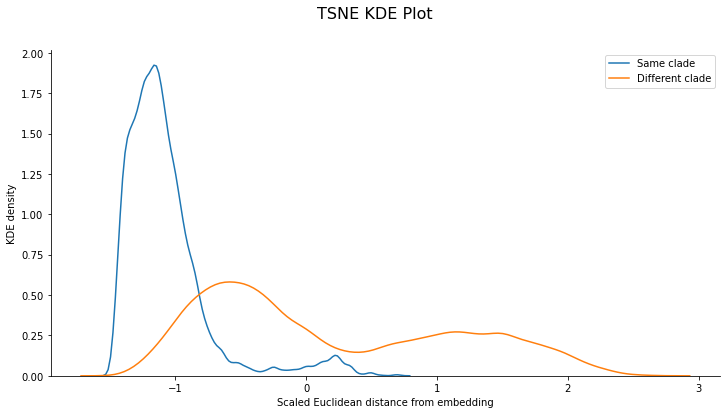

In [61]:
TSNE_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_t-sne.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('TSNE KDE Plot', fontsize=16)
sns.despine()

# Running UMAP on the Dataset

In [62]:
#principalDf = pd.read_csv(snakemake.input.pca)
UMAP_df = pd.read_csv("../zika-nextstrain/results/embed_umap.csv",index_col=0)

In [63]:
merged_umap_df = UMAP_df.merge(node_df, on="strain")

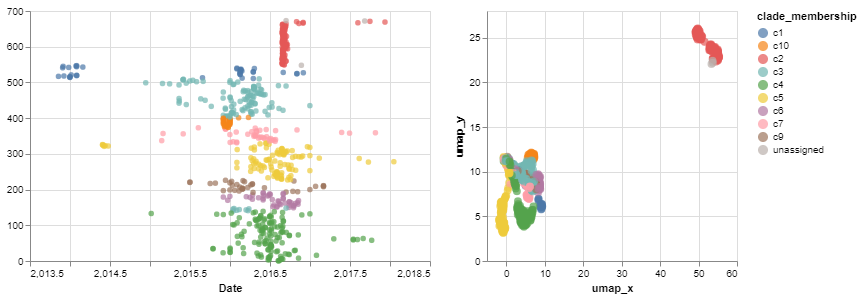

In [64]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership',
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

# HDBSCAN Output

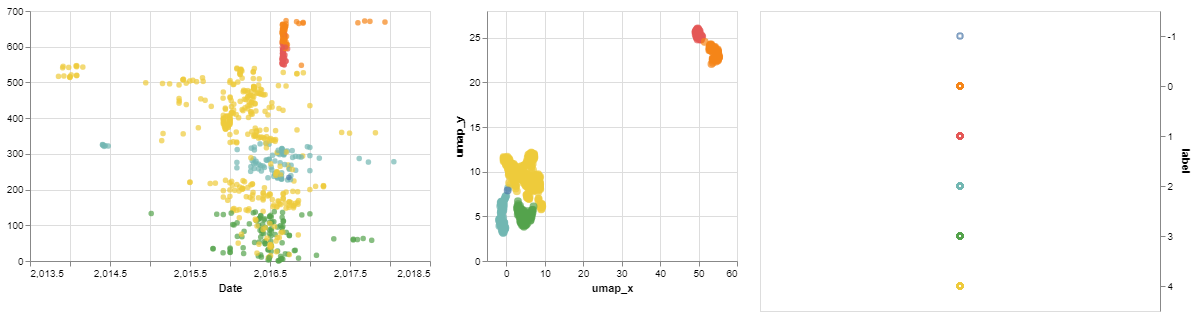

In [65]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_clickable(
    merged_umap_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'label:N',
    ['label'],
    ["clade_membership","strain:N"]
)
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]
chart
#chart.save("docs/UMAP" + virus_name + "Brush.html")
#chart.save("docs/UMAP" + virus_name + "Brush.png", scale_factor=2.0)

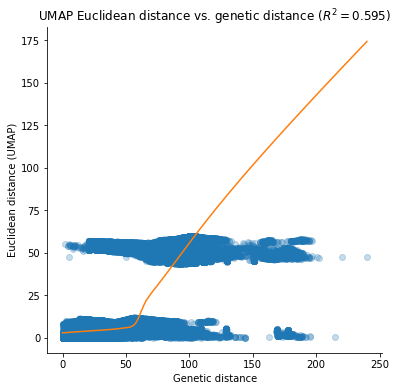

In [66]:
total_df_UMAP = pd.read_csv("../zika-nextstrain/results/scatterplot_umap.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax.set_xlabel("Genetic distance")
ax.set_ylabel("Euclidean distance (UMAP)")
ax.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_UMAP["pearson_coef"].values.tolist()[0]))

sns.despine()
#plt.savefig("docs/UMAPScatterplot" + virus_name + ".png")

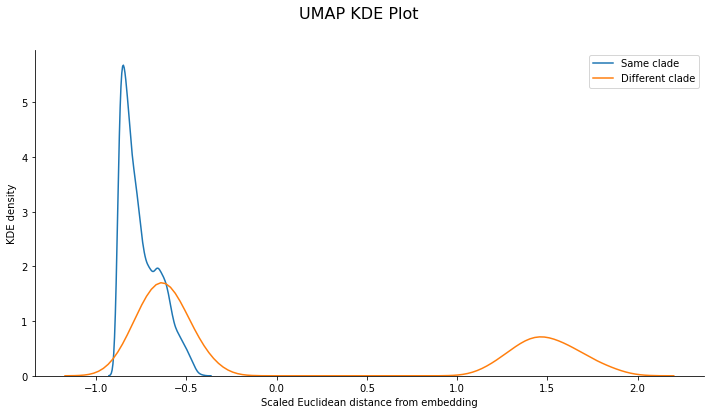

In [67]:
UMAP_KDE_df = pd.read_csv("../zika-nextstrain/results/KDEDensity_umap.csv",index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)

ax.set_xlabel("Scaled Euclidean distance from embedding")
ax.set_ylabel("KDE density")

fig.suptitle('UMAP KDE Plot', fontsize=16)
sns.despine()

# Linking all plots together clickable with Tree

In [68]:
merged_df = node_df.merge(
    principalDf,
    on="strain"
).merge(
    MDS_df,
    on="strain"
).merge(
    TSNE_df,
    on="strain"
).merge(
    UMAP_df,
    on="strain"
)

In [69]:
data = linking_tree_with_plots_clickable(
    merged_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['clade_membership'],
    ['strain','clade_membership']
)

In [70]:
PCAMDS = data[3]|data[1]|data[5]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save("../docs/FullLinkedChartClickable" + "Zika" + ".html")
#fullChart.save("docs/FullLinkedChartClickable" + virus_name + ".svg", scale_factor=2.0)
#drawing = svg2rlg("docs/FullLinkedChartClickable" + virus_name + ".svg")
#renderPDF.drawToFile(drawing, "docs/FullLinkedChartClickable" + virus_name + ".pdf")

/home/nandsra21/anaconda3/envs/cartography/lib/python3.6/site-packages/altair/utils/data.py:130: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return {'values': data.to_dict(orient='records')}


/home/nandsra21/anaconda3/envs/cartography/lib/python3.6/site-packages/altair/utils/data.py:130: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return {'values': data.to_dict(orient='records')}


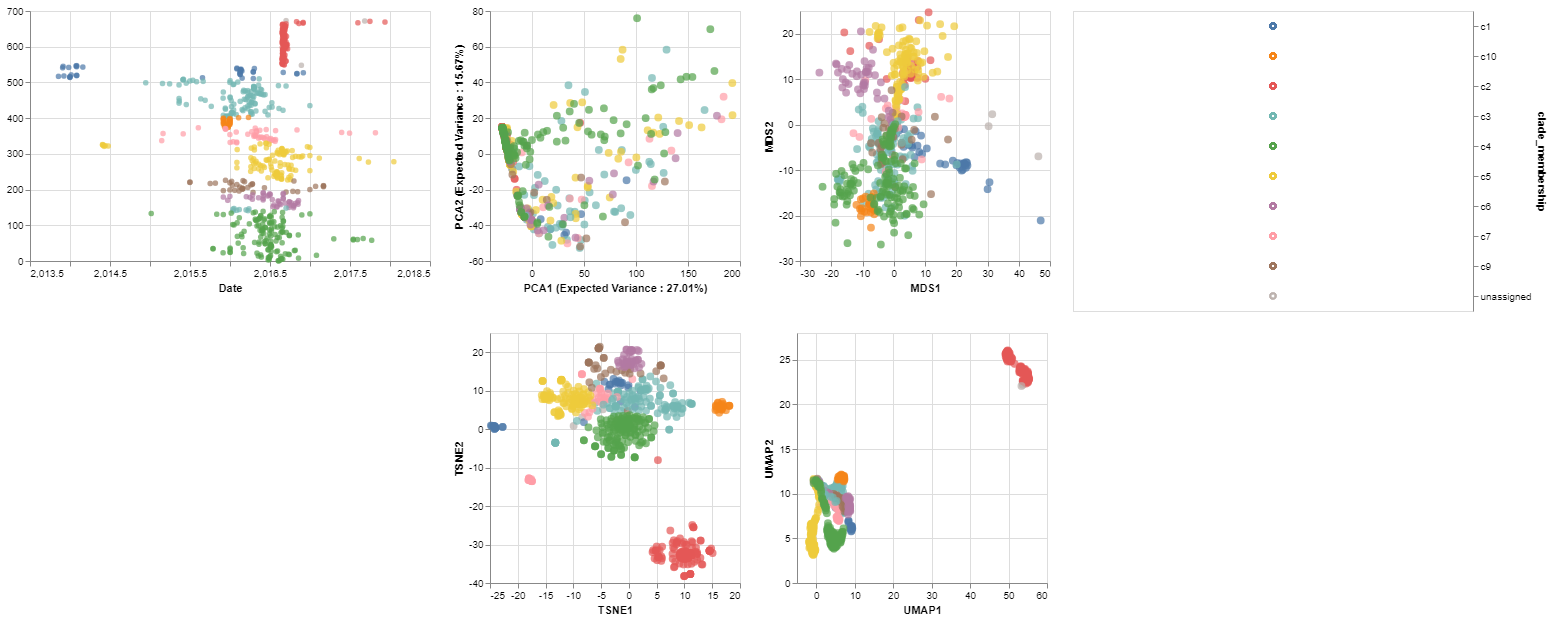

In [71]:
fullChart

## Scatterplots for all embeddings 
Concatenating all embedding data frames to plot genetic vs Euclidean distance for each embedding

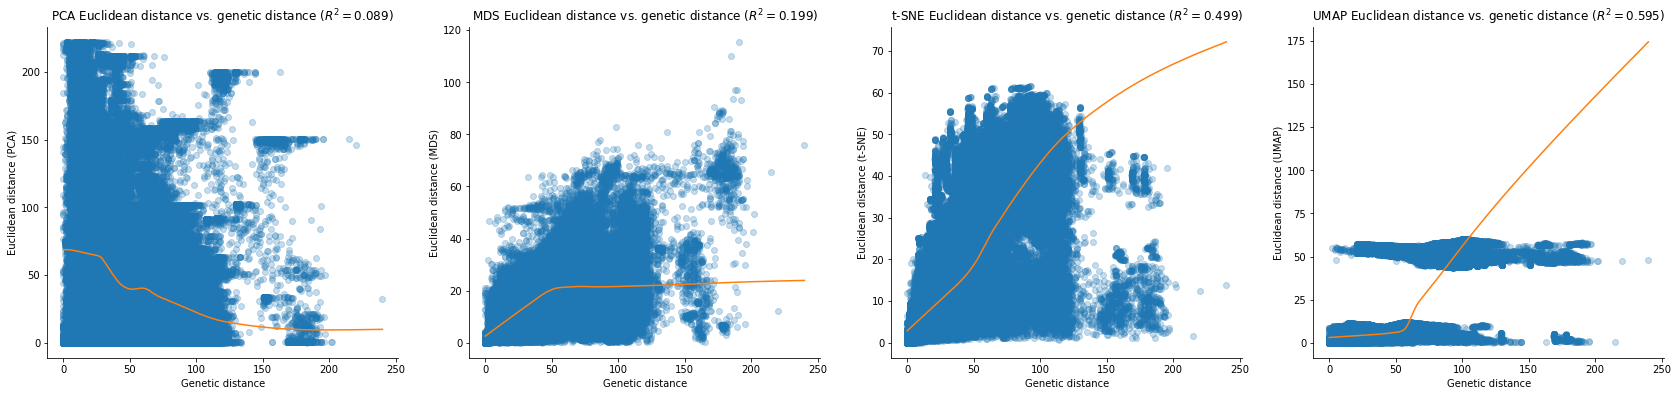

In [72]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title("PCA Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_PCA["pearson_coef"].values.tolist()[0]))

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (MDS)")
ax2.set_title("MDS Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_MDS["pearson_coef"].values.tolist()[0]))

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title("t-SNE Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_TSNE["pearson_coef"].values.tolist()[0]))

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title("UMAP Euclidean distance vs. genetic distance ($R^2=%.3f$)" % (total_df_UMAP["pearson_coef"].values.tolist()[0]))


sns.despine()
plt.savefig("../docs/FullScatterplot" + "Zika" + ".png")

## Within- and between-clade Euclidean distances for all embeddings

Use the complete embedding data frame to calculate pairwise Euclidean distances between samples and plot the results in a single figure.

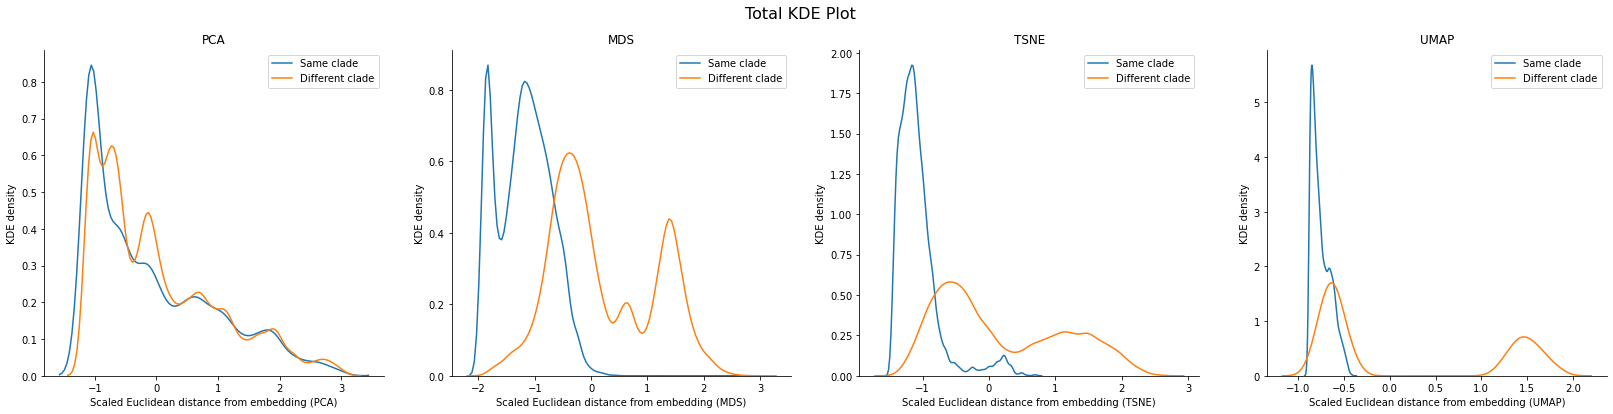

In [73]:
# ADD GENETIC PLOT HERE 
fig, axes = plt.subplots(1, 4, figsize=(28, 6))

ax = axes[0]
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(PCA_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('PCA')
ax.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax.set_ylabel("KDE density")

#MDS
ax = axes[1]
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(MDS_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('MDS')
ax.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax.set_ylabel("KDE density")

#TSNE
ax = axes[2]
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(TSNE_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('TSNE')
ax.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax.set_ylabel("KDE density")

#UMAP
ax = axes[3]
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 'within'")["scaled_distance"], label="Same clade", ax=ax)
ax = sns.kdeplot(UMAP_KDE_df.query("clade_status == 'between'")["scaled_distance"], label="Different clade", ax=ax)
ax.set_title('UMAP')
ax.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig("../docs/FullKDEDensity" + "Zika" + ".png")